In [2]:
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [3]:
import os
import sys
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import colorConverter as cc

import nibabel as nib

In [4]:
img_path = '/local/martipa/agemorph/thesis/images/age_plots'

In [5]:
def load_nii(path):
    nii = nib.load(path)
    vol = nii.get_data().astype(np.float32)
    return np.squeeze(vol)

In [6]:
run_dirs = glob.glob('../runs/*/predict')
run_dirs = sorted(run_dirs)

print('found {} runs'.format(len(run_dirs)), '\n')

for i, run in enumerate(run_dirs):
    print(i, run, '\n')

found 14 runs 

0 ../runs/gan_20190428_1448_gpu=7_bs=4_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_vr=0.5_is=5_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0]_clw=[1_1_10]/predict 

1 ../runs/gan_20190430_1720_gpu=7_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0_0]_clw=[1_1_10]_tag=beefier_decoder_more_summaries_batchnorm/predict 

2 ../runs/gan_20190503_1139_gpu=2_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=25.0_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_reg=True_clf=False_glw=[1.0_500.0_10.0_250.0_0.0_0.0_50.0]_clw=[1.0_1.0_10.0]_tag=new_arch/predict 

3 ../runs/gan_20190505_1942_gpu=7_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=25_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_reg=True_clf=False_glw=[1.0_100.0_10.0_100.0_0.0_0.0_25.0]_clw=[1_1_10]_tag=train_s1_eval_s2/predict 

4 ../runs/gan_20190505_2247_gpu=6_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=25_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=

In [7]:
# set run dir
run_dir = run_dirs[11]

pre_dirs = glob.glob(os.path.join(glob.escape(run_dir), '*', '*'))
pre_dirs = sorted(pre_dirs)

print('found {} pre_dirs'.format(len(pre_dirs)))

for i, pre_dir in enumerate(pre_dirs):
    #print(i, os.path.basename(pre_dir))
    print(i, pre_dir.split('/')[-2] + '/' + pre_dir.split('/')[-1])

found 12 pre_dirs
0 split_s0/gen_035
1 split_s0/gen_035_04
2 split_s0/gen_100
3 split_s0/gen_100_02
4 split_s0/gen_100_04
5 split_s0/gen_100_06
6 split_s0/gen_100_08
7 split_s0/gen_100_10
8 split_test/gen_025_04
9 split_test/gen_035_04
10 split_test/gen_100_04
11 split_test/gen_150_04


In [ ]:
# generator config, run_dir, etc...
pre_dir = pre_dirs[7]

csv_path = os.path.join(pre_dir, 'meta.csv')
csv = pd.read_csv(csv_path)

print('found meta.csv: {}'.format(csv.shape))

In [ ]:
# regressor
reg_dir = '../../age/runs/reg_20190517_0849_gpu=2_bs=32_lr=0.001_b1=0.9_b2=0.999_ep=0.0001_bn=True_mp=True_sw=None_lk=0.0_ls=[16_2_32_1_32_2_64_1_64_2_128_1_128_2_256_1_256_1]_lw=[1.0]_ls=mean_absolute_error_tag=split5_s1s2s3s4_s0/'
model_name = 'reg_0300'
model_file = os.path.join(reg_dir, model_name+'.h5')

if os.path.isfile(model_file):
    print('found model file')
else:
    print('model file not found!')

In [2]:
# gpu config
gpu_id = 7

if gpu_id is not None:                                                     
    gpu = '/gpu:' + str(gpu_id)                                            
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)                       
    config = tf.ConfigProto()                                              
    config.gpu_options.allow_growth = True                                 
    config.allow_soft_placement = True                                     
    set_session(tf.Session(config=config))                                 
else:                                                                      
    gpu = '/cpu:0'

In [1]:
csv = csv[~csv.img_path_0.isna()]
csv = csv[~csv.img_path_1.isna()]
csv = csv[~csv.img_path_yf.isna()]

csv = csv.reset_index(drop=True)

print('starting predict')

with tf.device(gpu):
    
    # load classifier model
    regressor = keras.models.load_model(model_file)
    
    for i, (_, row) in enumerate(csv.iterrows()):
        
        if i % 10 == 0:
            print('step', i)
        
        xr = load_nii(row['img_path_0'])[None, ..., None]
        yr = load_nii(row['img_path_1'])[None, ..., None]
        yf = load_nii(row['img_path_yf'])[None, ..., None]
        
        batch = np.concatenate([xr, yr, yf], axis=0)
        
        pred = regressor.predict([batch])
        
        index = (csv.img_id_0 == row['img_id_0']) & (csv.img_id_1 == row['img_id_1'])
        
        csv.loc[index, 'age_xr'] = pred[0]
        csv.loc[index, 'age_yr'] = pred[1]
        csv.loc[index, 'age_yf'] = pred[2]
        
print('finished predict')

csv_out_path = os.path.join(pre_dir, model_name+'.csv')

print('writing csv to {}'.format(csv_out_path))

csv.to_csv(csv_out_path, index=False)

NameError: name 'csv' is not defined

In [8]:
reg_csvs = glob.glob(os.path.join(glob.escape(run_dir), '*', '*_*_*', 'reg*.csv'))
reg_csvs = sorted(reg_csvs)

for i, reg_csv in enumerate(reg_csvs):
    print(i, '/'.join(reg_csv.split('/')[-2:]))

0 gen_100_02/reg_0300.csv
1 gen_100_04/reg_0300.csv
2 gen_100_06/reg_0300.csv
3 gen_100_08/reg_0300.csv
4 gen_100_10/reg_0300.csv


In [9]:
hist_ids = [0, 1, 2, 3]

csvs = []

for i, h_id in enumerate(hist_ids):
    csv_path = reg_csvs[h_id]
    csvs.append(pd.read_csv(csv_path))
    print((csvs[-1].age_yf - csvs[-1].age_xr).mean())
    print('{}: {}'.format(h_id, csvs[-1].shape))

2.458709313976231
0: (2680, 44)
3.2613418265954772
1: (2680, 44)
3.7211887516192537
2: (2680, 44)
4.053695822473782
3: (2680, 44)


(2680, 44)
2.458709313976231
0.9472134621098453
2.5436973571777344
(2680, 44)
3.2613418265954772
1.3763500137326445
3.3484954833984375
(2680, 44)
3.7211887516192537
1.748503166810171
3.8511028289794815
(2680, 44)
4.053695822473782
2.098048921227456
4.2111968994140625


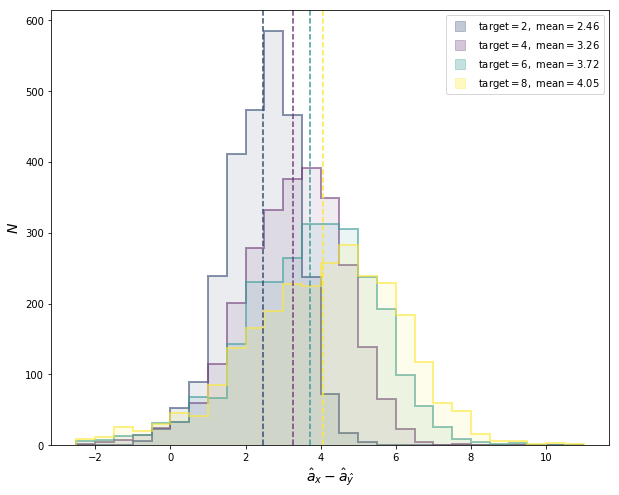

In [14]:
c = ['#384D75', '#723F7E', '#3C9D9A', '#FDE835']
l = [2, 4, 6, 8]

plt.figure(figsize=(10, 8))


handles = []

for i, csv in enumerate(csvs):
    # outputs should be the same for same first image, so drop duplicates
    #csv_unique = csv.drop_duplicates(subset=['img_id_0'])
    csv_unique = csv
    print(csv_unique.shape)

    x = np.arange(-2.5, 11.5, 0.5)
    y = csv_unique.age_yf - csv_unique.age_xr

    print(y.mean())
    print(y.std())
    print(y.median())
    
    handles.append(mlines.Line2D([], [], color=cc.to_rgba(c[i], 0.3), marker='s',
                linestyle='None', markersize=10, label='target$ = {},\ $mean$ = {:.2f}$'.format(l[i], y.mean())))

    plt.axvline(y.mean(), c=c[i], linestyle='--')
    
    plt.hist(y, x, alpha=0.6, histtype=u'step', linewidth=2, color=c[i])
    plt.hist(y, x, alpha=0.1, linewidth=2, color=c[i])

plt.legend(handles=handles, loc=1)

plt.xlabel('$\hat a_x - \hat a_{\hat y}$', fontsize=14)
plt.ylabel('$N$', fontsize=14)

save = False
#save = True
if save:
    plt.savefig(os.path.join(img_path, 'hist_fixed.pdf'), dpi=250)

plt.show()